In [191]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam

from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [196]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [89]:
DATASET_PATH = Path('D:/Dev/Datasets/FoodClassification')
PREPROC_PATH = Path('D:/Dev/Datasets/PreprocFoodClassification')
PREPROC_PATH.mkdir(parents=True, exist_ok=True)

In [179]:
# Transformations for the images
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

originalDataset = datasets.ImageFolder(root=DATASET_PATH)

In [180]:
# Preprocess the dataset and save it to disk to save time loading from disk
for idx, (img, label) in enumerate(tqdm(originalDataset, desc="Preprocessing images")):
    imgTensor = transforms(img)
    
    # Get the class folder path in preprocessed directory
    className = originalDataset.classes[label]
    classFolder = PREPROC_PATH / className
    classFolder.mkdir(parents=True, exist_ok=True)
    
    # Save tensor as a .pt file
    tensor_path = classFolder / f"{idx}.pt"
    torch.save((imgTensor, label), tensor_path)

Preprocessing images:  59%|█████▉    | 3726/6340 [00:31<00:17, 146.84it/s]C:\Users\Peblo\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Preprocessing images: 100%|██████████| 6340/6340 [00:50<00:00, 125.77it/s]


In [181]:
CLASSES = originalDataset.classes
NUM_CLASES = len(CLASSES)

print(NUM_CLASES, CLASSES)

15 ['apple_pie', 'baked_potato', 'burger', 'cheesecake', 'crispy_chicken', 'donut', 'fried_rice', 'fries', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sandwich', 'sushi', 'taco']


In [182]:
# Custom datasert to load the preprocessed data
class FoodDataset(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.files = list(self.root.glob("**/*.pt"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_tensor, label = torch.load(self.files[idx])
        return img_tensor, label

dataset = FoodDataset(PREPROC_PATH)

In [183]:
# Perform the split into training and validation
trainSize = int(0.8 * len(dataset))
valSize = len(dataset) - trainSize
trainDataset, valDataset = random_split(dataset, [trainSize, valSize])

In [184]:
# Create the loaders
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False)

C:\Users\Peblo\AppData\Local\Temp\ipykernel_34796\1959813092.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor, label = torch.load(self.files[idx])


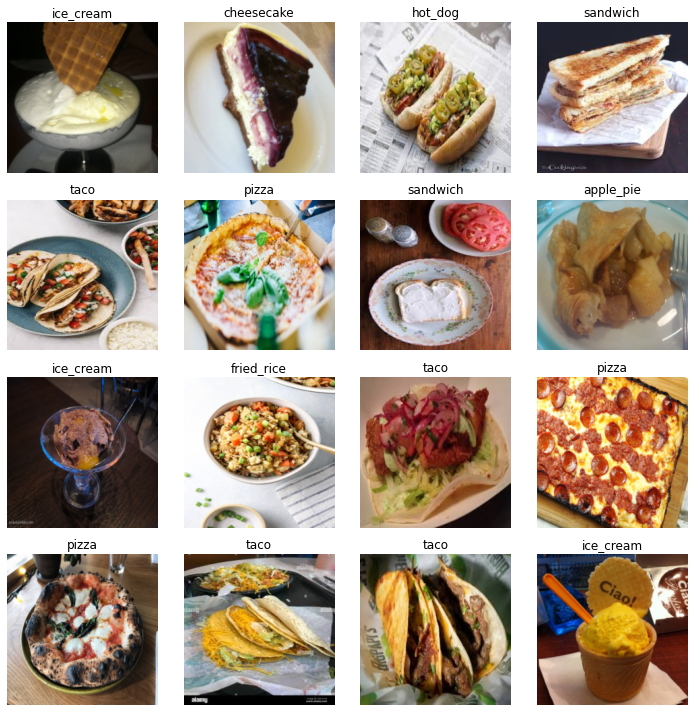

In [193]:
# Plot some of the images and their classes
images, labels = next(iter(trainLoader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10)) 
axes = axes.flatten()

for ax, img, label in zip(axes, images, labels):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(CLASSES[label])

plt.tight_layout()
plt.show()

In [185]:
IMG_CHANNELS = 3
kernel_size = 3

FLATTENED_SIZE = 256 * 14 * 14

model = nn.Sequential(
    nn.Conv2d(IMG_CHANNELS, 32, kernel_size, stride=1, padding=1), # 32 x 224 x 224
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2), # 32 x 112 x 112

    nn.Conv2d(32, 64, kernel_size, stride=1, padding=1), # 64 x 112 x 112
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.MaxPool2d(2, stride=2), # 64 x 56 x 56

    nn.Conv2d(64, 128, kernel_size, stride=1, padding=1), # 128 x 56 x 56
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2), # 128 x 28 x 28

    nn.Conv2d(128, 256, kernel_size, stride=1, padding=1), # 256 x 28 x 28
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2), # 256 x 14 x 14


    nn.Flatten(),

    nn.Linear(FLATTENED_SIZE, 256),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, 256),
    nn.ReLU(),

    nn.Linear(256, NUM_CLASES)
)

In [195]:
model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()

In [187]:
lossFunc = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [188]:
def getBatchAccuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct

In [189]:
def validate():
    val_loss = 0
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            val_loss += lossFunc(output, y).item()
            correct += getBatchAccuracy(output, y)

    avg_loss = val_loss / len(valLoader)
    accuracy = correct / valSize

    print(f'(val) Loss: {avg_loss:.4f} Accuracy: {accuracy:.4f}')

def train():
    train_loss = 0
    correct = 0
    model.train()
    
    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = lossFunc(output, y)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item()


        correct += getBatchAccuracy(output, y)

    avg_loss = train_loss / len(trainLoader)
    accuracy = correct / trainSize

    print(f'(train) Loss: {avg_loss:.4f} Accuracy: {accuracy:.4f}')

In [190]:
epochs = 100

# Train the model
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    train()
    validate()

Epoch 0


C:\Users\Peblo\AppData\Local\Temp\ipykernel_34796\1959813092.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor, label = torch.load(self.files[idx])


(train) Loss: 3.1201 Accuracy: 0.1007
(val) Loss: 2.5398 Accuracy: 0.1483
Epoch 1
(train) Loss: 2.5294 Accuracy: 0.1366
(val) Loss: 2.4824 Accuracy: 0.1530
Epoch 2
(train) Loss: 2.4762 Accuracy: 0.1581
(val) Loss: 2.3345 Accuracy: 0.2090
Epoch 3
(train) Loss: 2.4407 Accuracy: 0.1621
(val) Loss: 2.4338 Accuracy: 0.1703
Epoch 4
(train) Loss: 2.3588 Accuracy: 0.2015
(val) Loss: 2.3226 Accuracy: 0.2098
Epoch 5
(train) Loss: 2.3637 Accuracy: 0.1952
(val) Loss: 2.3142 Accuracy: 0.2492
Epoch 6
(train) Loss: 2.3088 Accuracy: 0.2163
(val) Loss: 2.2815 Accuracy: 0.2319
Epoch 7
(train) Loss: 2.2852 Accuracy: 0.2216
(val) Loss: 2.3171 Accuracy: 0.2106
Epoch 8
(train) Loss: 2.2856 Accuracy: 0.2263
(val) Loss: 2.3174 Accuracy: 0.2279
Epoch 9
(train) Loss: 2.2273 Accuracy: 0.2392
(val) Loss: 2.3963 Accuracy: 0.2208
Epoch 10
(train) Loss: 2.2110 Accuracy: 0.2457
(val) Loss: 2.2768 Accuracy: 0.2547
Epoch 11
(train) Loss: 2.1768 Accuracy: 0.2463
(val) Loss: 2.1814 Accuracy: 0.2571
Epoch 12
(train) Loss:

C:\Users\Peblo\AppData\Local\Temp\ipykernel_34796\1959813092.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor, label = torch.load(self.files[idx])


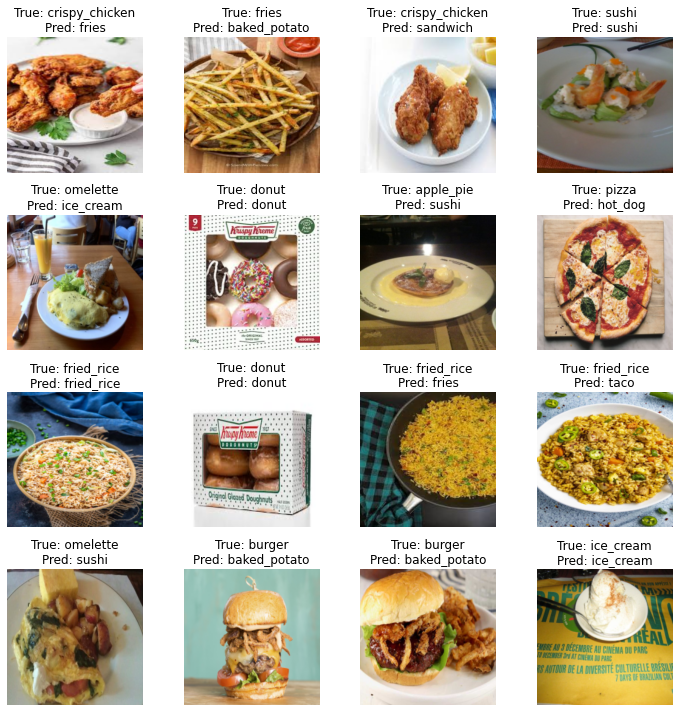

In [194]:
# Print the model predictions
model.eval()
images, labels = next(iter(valLoader))

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for ax, img, label, pred in zip(axes, images, labels, preds):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {CLASSES[label]}\nPred: {CLASSES[pred]}')

plt.tight_layout()
plt.show()

In [199]:
# Save the model
torch.save(model.state_dict(), Path('./FCModel.pth'))